## 1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю (реальные данные + результат модели, графики двух лоссов)
 * Дополнительно: посмотреть зависимость от количества изначальных реальных данных (график) 

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Device

In [3]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


### Константы

In [141]:
n_epochs = 500
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

### Генератор

In [142]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu'
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            
            return layers

        self.model = nn.Sequential(
            # input 64x2
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        pred = self.model(z)
        return pred

### Дискриминатор

In [143]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)
        
        # с большим разбросом получился лучше результат
        nn.init.uniform_(self.weights, -0.5, 0.5) 
        nn.init.uniform_(self.bias, -0.5, 0.5)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [144]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, pred):
        validity = self.model(pred)

        return validity

### Реальные данные

In [145]:
x = np.linspace(-50,50,10000)

def func_y(x):
    return np.sin(x)/x - x/10

#данные два списка надо объединить в один вида data = [(x_0,y_0), (x_1, y_1),..] <- реальные данные 

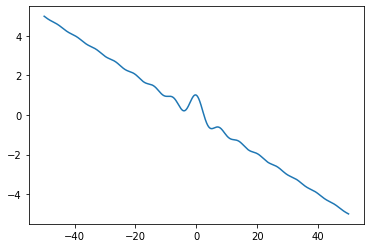

In [146]:
plt.plot(x, func_y(x))
plt.show()

In [147]:
x_y_data = np.array([(x_i, func_y(x_i)) for x_i in x])

In [148]:
x_y_data[0:4]

array([[-50.        ,   4.9947525 ],
       [-49.989999  ,   4.99355857],
       [-49.979998  ,   4.9923651 ],
       [-49.969997  ,   4.99117212]])

In [149]:
real_data = torch.utils.data.DataLoader(
    x_y_data,
    batch_size=batch_size,
    shuffle=True,
)

In [150]:
dataiter = iter(real_data)
data = dataiter.next()

# Batch size = 64
print(len(data))
print(data)

64
tensor([[ 21.8172,  -2.1738],
        [ -6.6257,   0.7133],
        [ -3.2953,   0.2831],
        [ 19.1569,  -1.8999],
        [ -6.7457,   0.7407],
        [-16.6767,   1.6182],
        [ -7.3357,   0.8520],
        [ -9.4559,   0.9423],
        [  4.4154,  -0.6581],
        [ 16.0066,  -1.6190],
        [ 19.5970,  -1.9250],
        [-18.0268,   1.7620],
        [ 17.7668,  -1.8264],
        [-23.8074,   2.3400],
        [ 30.9281,  -3.1080],
        [-14.1764,   1.4881],
        [ 19.9970,  -1.9541],
        [-17.0867,   1.6512],
        [-38.8389,   3.9073],
        [-25.2475,   2.5293],
        [-30.1880,   2.9876],
        [-36.6887,   3.6458],
        [-23.4473,   2.3024],
        [-25.7176,   2.5932],
        [ -1.0351,   0.9343],
        [ 47.0897,  -4.7082],
        [-41.2291,   4.1137],
        [ 48.9899,  -4.9185],
        [-32.8583,   3.3160],
        [ 33.6484,  -3.3414],
        [ 35.6686,  -3.5920],
        [-44.7395,   4.4893],
        [ 16.9667,  -1.7528],
       

### Модель

In [151]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

### Обучение

In [152]:
d_loss_history = []
g_loss_history = []

[Epoch 499/500] [Batch 132/157] [D loss: 0.729329] [G loss: 0.912468]


<Figure size 432x288 with 0 Axes>

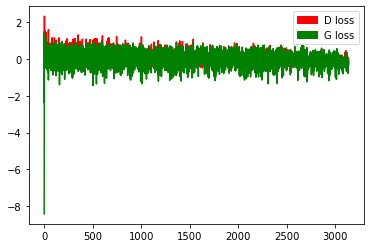

In [153]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

for epoch in range(n_epochs):
    for i, data in enumerate(real_data):
        
        cur_batch_size = len(data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_ex = Variable(data.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума (нормальное распределение тут не подойдёт)
        z = Variable(torch.FloatTensor(np.random.uniform(-50, 50, (cur_batch_size, latent_dim)))).to(device)

        gen_ex = generator(z)

        validity = discriminator(gen_ex)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_ex)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_ex.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()


### Тестирование

In [164]:
generator.eval()

test_z = Variable(torch.from_numpy(np.random.uniform(-50, 50, (64, latent_dim)).astype(np.float64)).float()).to(device)

with torch.no_grad():
    test_pred = generator(test_z)

In [165]:
cnt = 0
error = 0.0
for i in range(len(test_pred)):
    x = test_pred[i][0]
    y_real = func_y(x)  
    y_pred = test_pred[i][1]  
    count +=1
    error += abs(y_real - y_pred)

print("\nTotal mean error: %.10f" % (error/count))


Total mean error: 0.0194209702


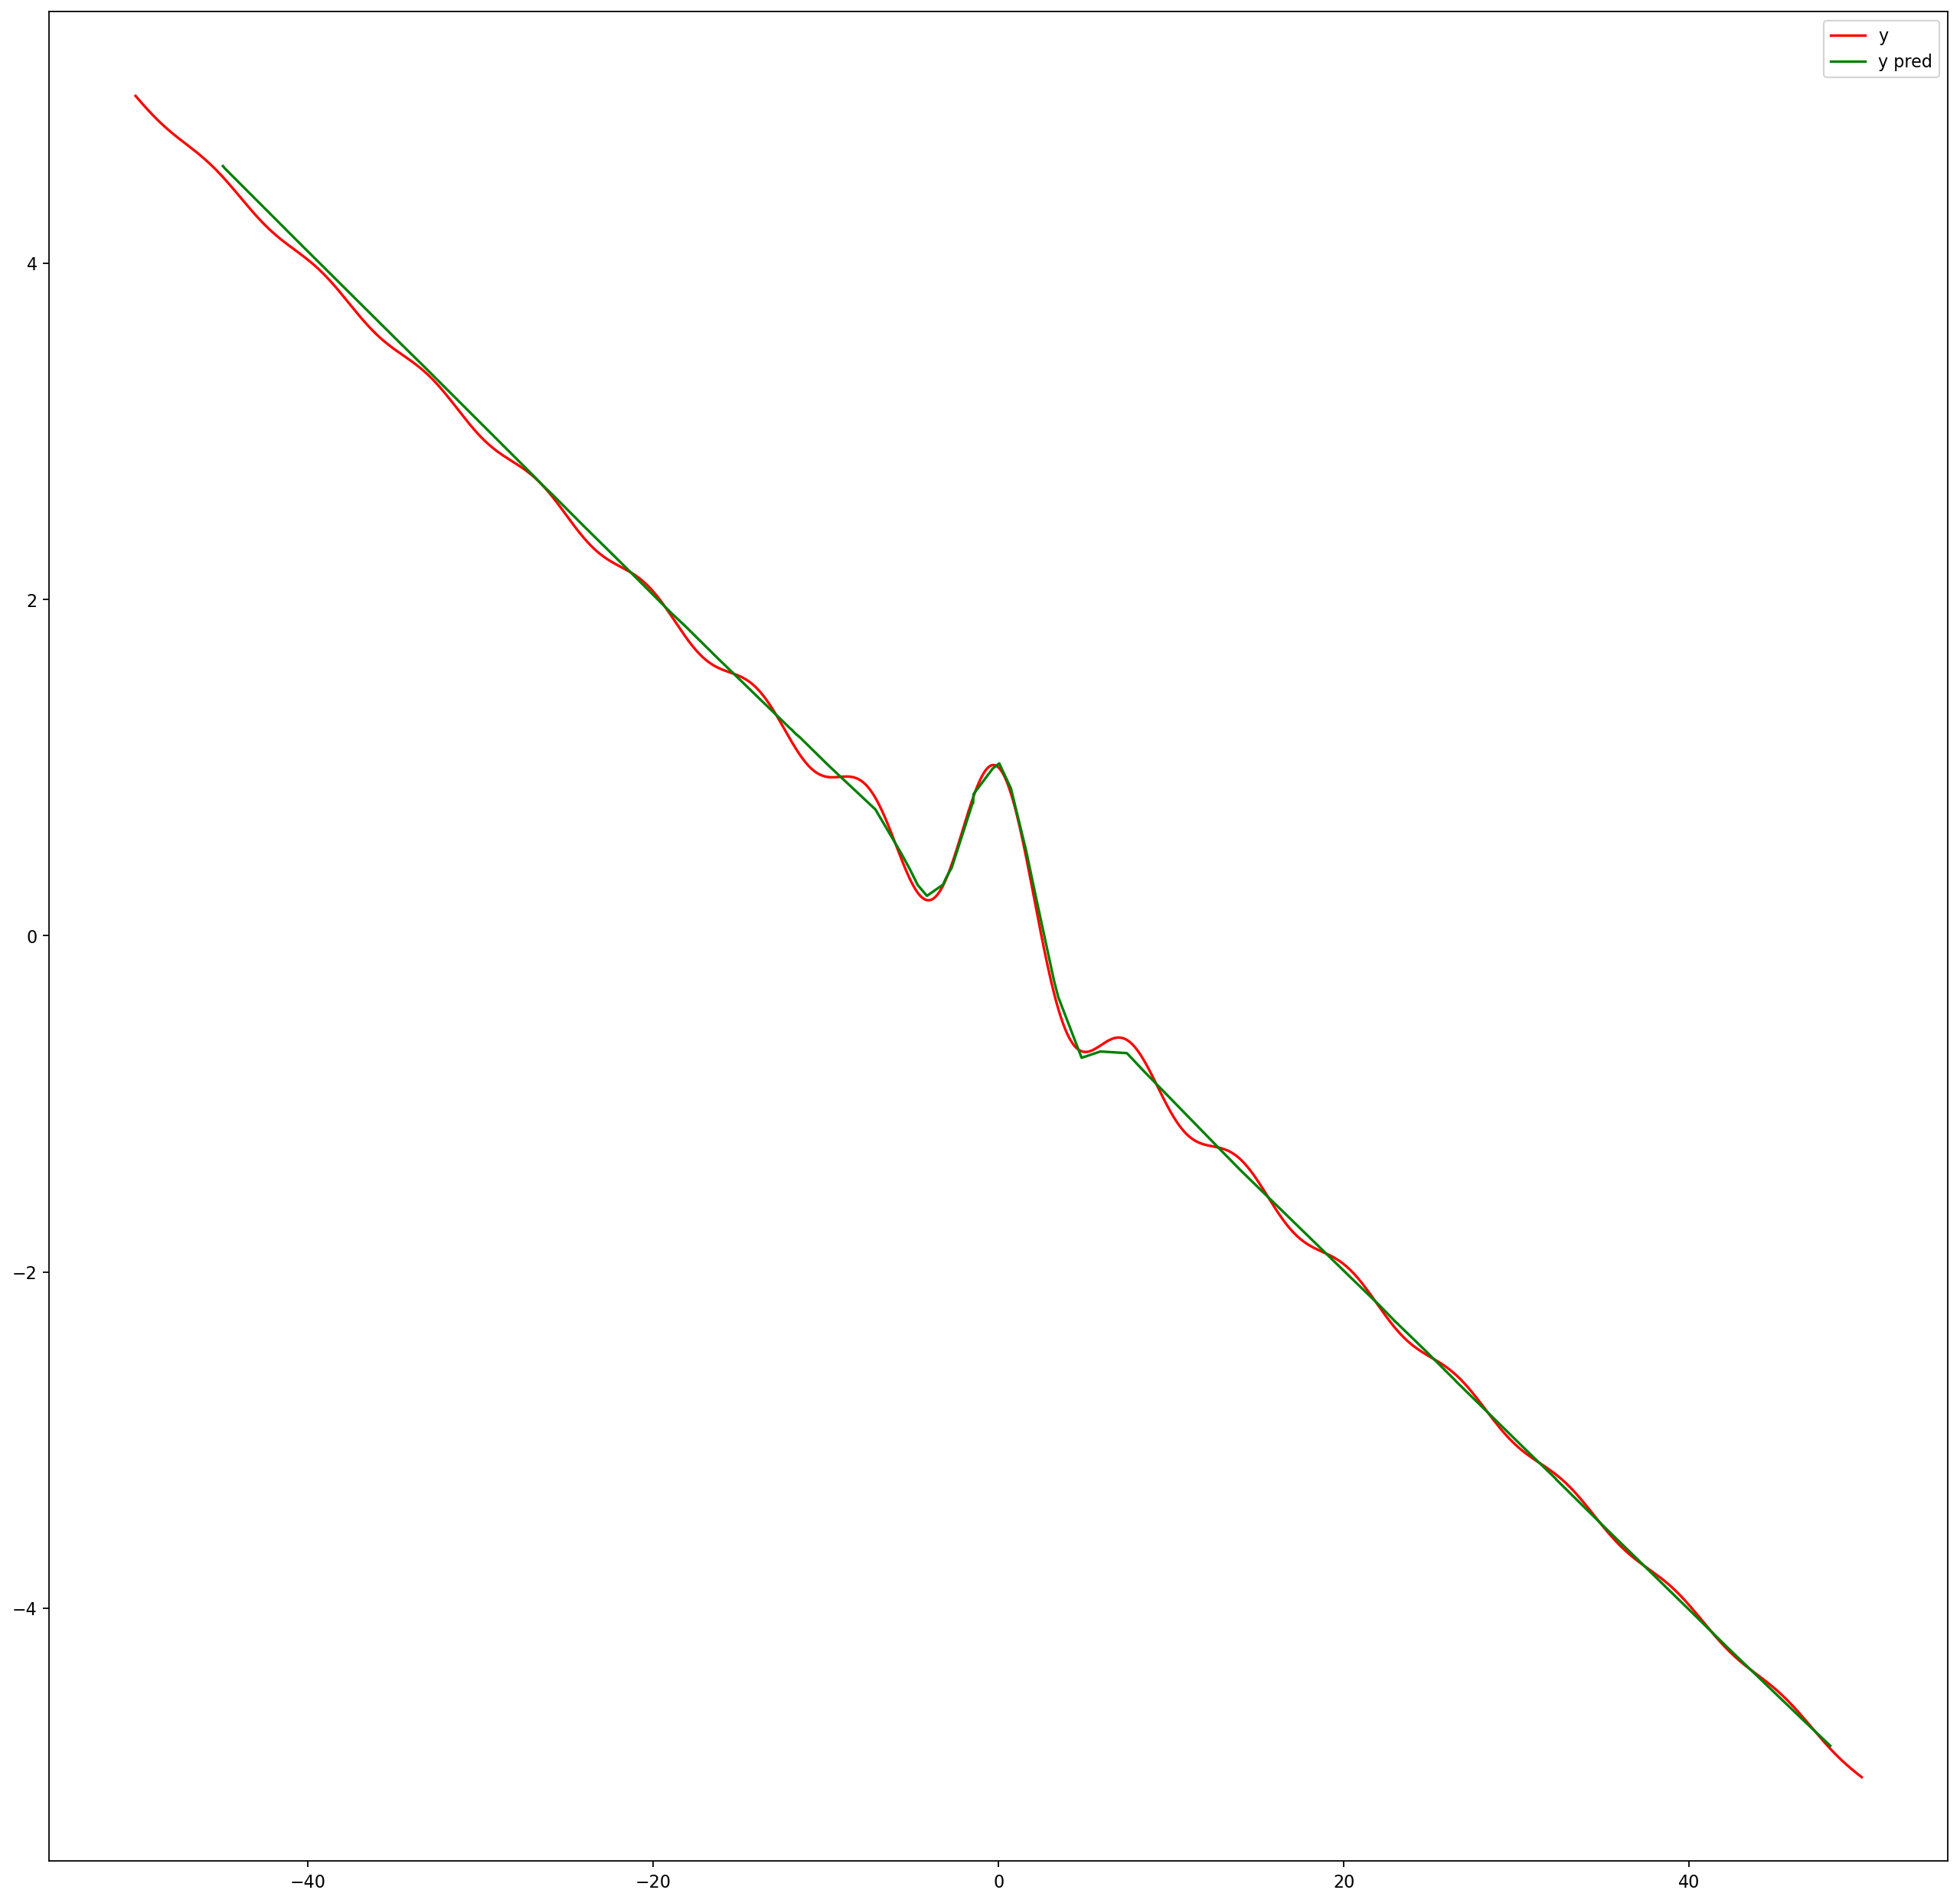

In [167]:
plt.figure(num=None, figsize=(20, 20), dpi=160)

x = np.linspace(-50, 50, 1000)
plt.plot(x, func_y(x), label='y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')


plt.legend()
plt.show()

### Повтор с меньшим числом начальных данных (1000 вместо 10000 на том же интервале)

[Epoch 498/500] [Batch 7/16] [D loss: 0.778901] [G loss: 0.702256]


<Figure size 432x288 with 0 Axes>

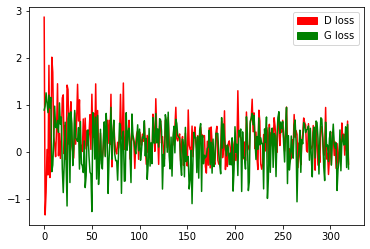

In [169]:
x = np.linspace(-50,50,1000)
x_y_data = np.array([(x_i, func_y(x_i)) for x_i in x])
real_data = torch.utils.data.DataLoader(
    x_y_data,
    batch_size=batch_size,
    shuffle=True,
)
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()
d_loss_history = []
g_loss_history = []
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

for epoch in range(n_epochs):
    for i, data in enumerate(real_data):
        
        cur_batch_size = len(data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_ex = Variable(data.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума (нормальное распределение тут не подойдёт)
        z = Variable(torch.FloatTensor(np.random.uniform(-50, 50, (cur_batch_size, latent_dim)))).to(device)

        gen_ex = generator(z)

        validity = discriminator(gen_ex)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_ex)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_ex.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()



Total mean error: 0.0374660157


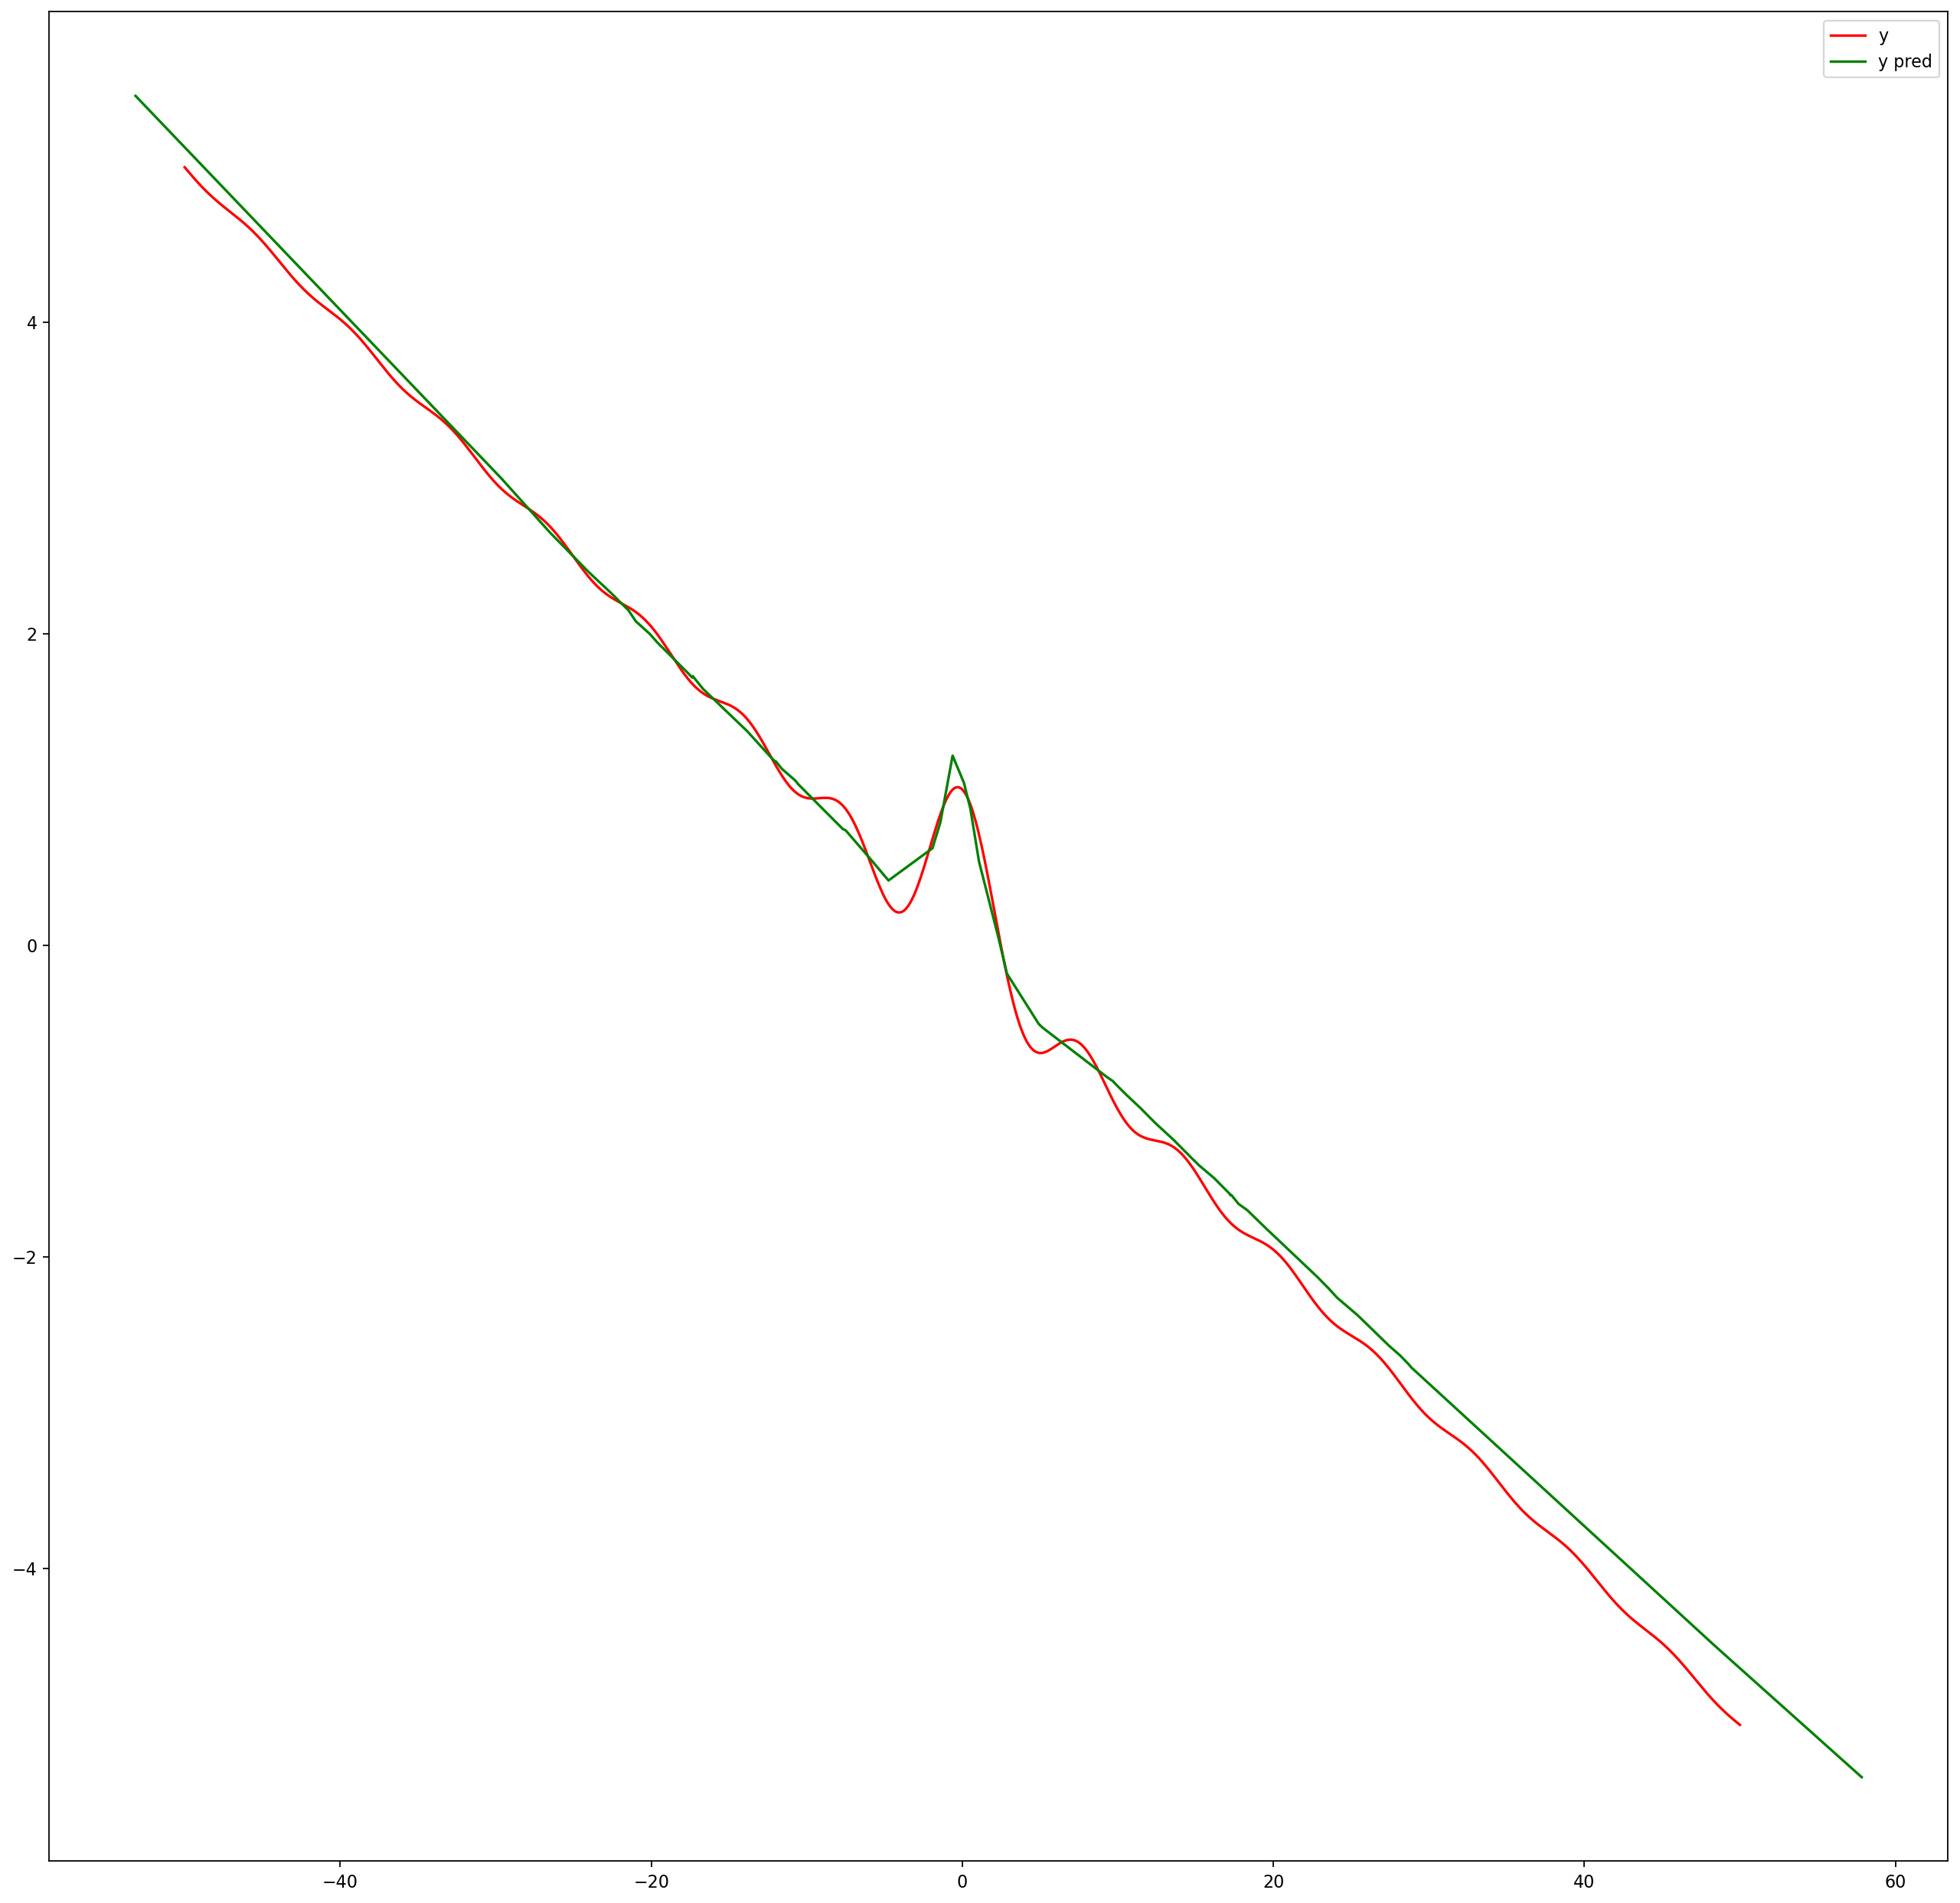

In [170]:
generator.eval()

test_z = Variable(torch.from_numpy(np.random.uniform(-50, 50, (64, latent_dim)).astype(np.float64)).float()).to(device)

with torch.no_grad():
    test_pred = generator(test_z)

cnt = 0
error = 0.0
for i in range(len(test_pred)):
    x = test_pred[i][0]
    y_real = func_y(x)  
    y_pred = test_pred[i][1]  
    count +=1
    error += abs(y_real - y_pred)

print("\nTotal mean error: %.10f" % (error/count))

plt.figure(num=None, figsize=(20, 20), dpi=160)

x = np.linspace(-50, 50, 1000)
plt.plot(x, func_y(x), label='y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')


plt.legend()
plt.show()

## 2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

Нашёл пример на сайте pytorch, о котором Вы говорили, по ссылке https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html  <br>
Я адаптировал его, только немного изменил архитектуру - в датасете MNIST размер картинок меньше, так что я убрал один свёрточный слой. Картинки проще, и не цветные, так что я думаю, что это оправданный ход, который не должен сделать результат хуже относительно результата из примера. <br>
Ну и само собой пришлось посчитать размеры тензоров между слоями, чтобы придти к нужному размеру в конце.

In [4]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [5]:
# Root directory for dataset
dataroot = "./data/mnist"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

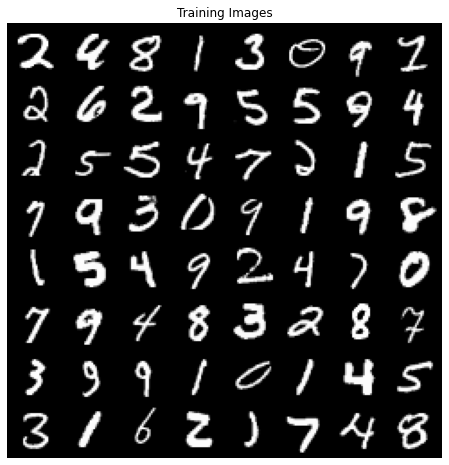

In [21]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.MNIST(
                dataroot,
                train=True,
                download=True,
                transform=transforms.Compose(
                    [transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
                ),
            )
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
real_batch[0].shape

torch.Size([128, 1, 28, 28])

In [23]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

В коментариях дальше во всех размерностях отброшена первая размерность - размер батча.

In [30]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [31]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [32]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False), # kernel_size changed
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            # state size. 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [33]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [34]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

В отличие от примера из лекции тут на каждом шаге обучения сначала обучается дискриминатор, а потом генератор, но как я понимаю, это вообще не важно - первая итерация обучения всё равно происходит на случайных весах, а дальше важно именно, что мы итеративно обучаем обе части одновременно. <br>
А так идея та же - сгенерить данные, состоящие из 2х частей - реальной из датасета, и сгенерённой генератором, обучить на них дискриминатор, используя результаты обучения дискриминатора обучить генератор.

In [35]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.6728	Loss_G: 1.5035	D(x): 0.3823	D(G(z)): 0.4494 / 0.2545
[0/5][50/469]	Loss_D: 0.1618	Loss_G: 5.3925	D(x): 0.9564	D(G(z)): 0.0981 / 0.0064
[0/5][100/469]	Loss_D: 0.1178	Loss_G: 4.3112	D(x): 0.9443	D(G(z)): 0.0510 / 0.0211
[0/5][150/469]	Loss_D: 0.1523	Loss_G: 3.6326	D(x): 0.9371	D(G(z)): 0.0780 / 0.0395
[0/5][200/469]	Loss_D: 0.3118	Loss_G: 4.0997	D(x): 0.9502	D(G(z)): 0.2153 / 0.0233
[0/5][250/469]	Loss_D: 1.4480	Loss_G: 8.5051	D(x): 0.9969	D(G(z)): 0.7293 / 0.0004
[0/5][300/469]	Loss_D: 0.1435	Loss_G: 3.0251	D(x): 0.9138	D(G(z)): 0.0448 / 0.0635
[0/5][350/469]	Loss_D: 0.2464	Loss_G: 3.2404	D(x): 0.9170	D(G(z)): 0.1401 / 0.0486
[0/5][400/469]	Loss_D: 0.1021	Loss_G: 3.2590	D(x): 0.9478	D(G(z)): 0.0451 / 0.0509
[0/5][450/469]	Loss_D: 6.8091	Loss_G: 0.1277	D(x): 0.0030	D(G(z)): 0.0003 / 0.8870
[1/5][0/469]	Loss_D: 0.3106	Loss_G: 3.3176	D(x): 0.8903	D(G(z)): 0.1612 / 0.0500
[1/5][50/469]	Loss_D: 0.1169	Loss_G: 3.0028	D(x): 0.9222	D(G(z)): 

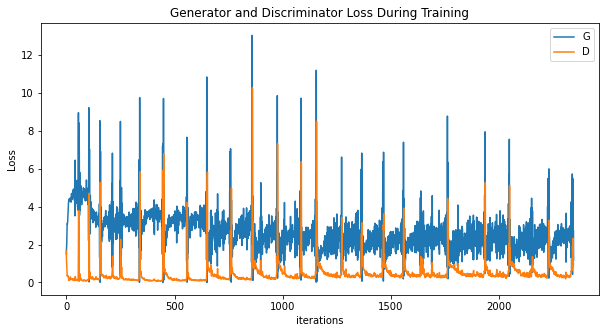

In [36]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

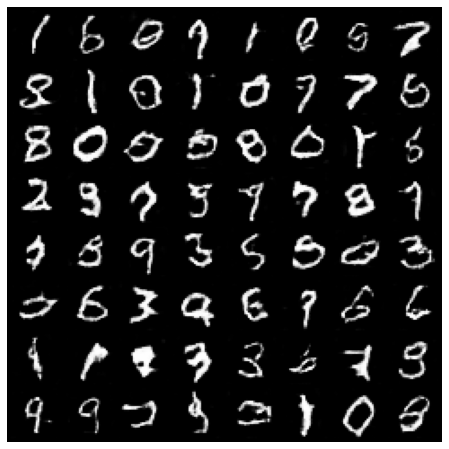

In [37]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

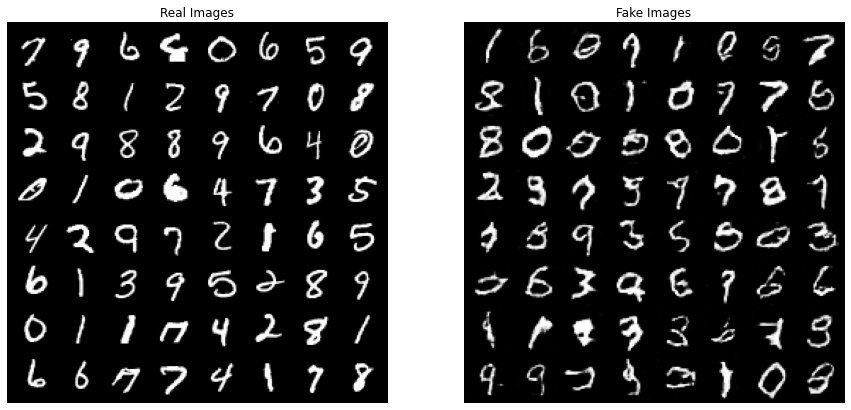

In [38]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()